# 💳 **Zaka & BLACKBOX Technical Challenge**
## Credit Card Anomaly Detection  
### by Khalil Kurdi

---

This notebook presents an end-to-end solution for detecting fraudulent credit card transactions using **unsupervised machine learning techniques**. The objective is to identify potential frauds (anomalies) within a highly imbalanced dataset, where fraud cases represent less than 0.2% of the total.

We explore the use of:
- 🟡 **Isolation Forest**: a tree-based anomaly detection method trained on the full dataset with different contamination values.
- 🟢 **Autoencoder (Bonus)**: a neural network trained only on normal transactions to detect fraud based on reconstruction error.

---

### 📌 Structure of the Notebook

1. **Data Loading & Exploration**
2. **Preprocessing & Scaling**
3. **Unsupervised Isolation Forest Modeling**
4. **Evaluation & Metrics**
   - Confusion Matrix
   - Precision, Recall, F1-score
   - ROC AUC Score
   - ROC Curve
5. **Model Comparison Summary**




In [3]:
!pip install pandas scikit-learn matplotlib seaborn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Data Loading & Exploration
In this section we need to have a **Kaggle** API as a .JSON file, so we can download the dataset directly into the notebook.

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilothe16th","key":"f818302759a21db2ac2c6360911a9f2a"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.40GB/s]


In [8]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [9]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


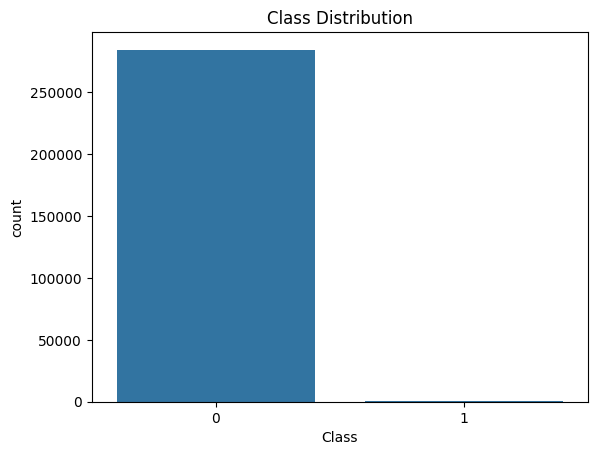

In [10]:
# displaying dataset size and distribution
print(df.shape)
print(df['Class'].value_counts())  # 0 = normal, 1 = fraud

sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

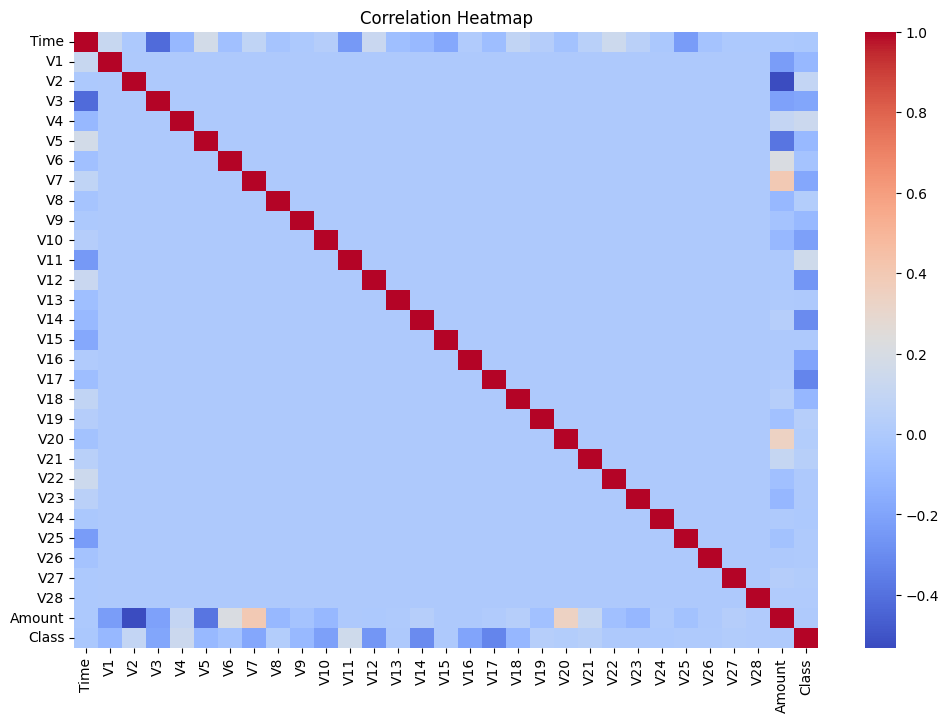

In [11]:
# Visual representation of the correlation matrix, showing the strength and direction of relationships between multiple variables in a dataset
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [40]:
# Anomaly Visualization
import plotly.express as px
from sklearn.decomposition import PCA

# Sample and prepare data
vis_df = df.sample(n=30000, random_state=42) #30k sample
X_vis = vis_df.drop(columns=['Class', 'anomaly'])
X_scaled = StandardScaler().fit_transform(X_vis)

# Apply PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_scaled)

# Add results to DataFrame
vis_df['PCA1'] = pca_results[:, 0]
vis_df['PCA2'] = pca_results[:, 1]
vis_df['TrueLabel'] = vis_df['Class'].map({0: "Normal", 1: "Fraud"})
vis_df['Prediction'] = vis_df['anomaly'].map({0: "Normal", 1: "Anomaly"})

# Plot
fig = px.scatter(
    vis_df,
    x="PCA1", y="PCA2",
    color="Prediction",
    symbol="TrueLabel",
    color_discrete_map={"Normal": "green", "Anomaly": "red"},
    title="PCA Projection of Transactions with Anomaly Detection",
    opacity=0.6,
    hover_data=["Class", "anomaly"]
)

fig.show()


# Step 2: Preprocessing & Scaling

In [12]:
# Standardizing the 'Amount' and 'Time' features, creating new scaled versions
scaler = StandardScaler()
df['Amount_Scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_Scaled'] = scaler.fit_transform(df[['Time']])

df.drop(columns=['Amount', 'Time'], inplace=True)

# Step 3: Unsupervised Isolation Forest Modeling

In [13]:
# Train isolation forest
features = df.drop(columns=['Class'])
model = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)

model.fit(features)
df['anomaly'] = model.predict(features)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # Convert to 0 = normal, 1 = anomaly


# Step 4: Evaluation & Metrics

In [14]:
# Confusion matrix plot
print(confusion_matrix(df['Class'], df['anomaly']))
print(classification_report(df['Class'], df['anomaly']))
print("ROC AUC Score:", roc_auc_score(df['Class'], df['anomaly']))

[[283109   1206]
 [   273    219]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.15      0.45      0.23       492

    accuracy                           0.99    284807
   macro avg       0.58      0.72      0.61    284807
weighted avg       1.00      0.99      1.00    284807

ROC AUC Score: 0.7204400885654566


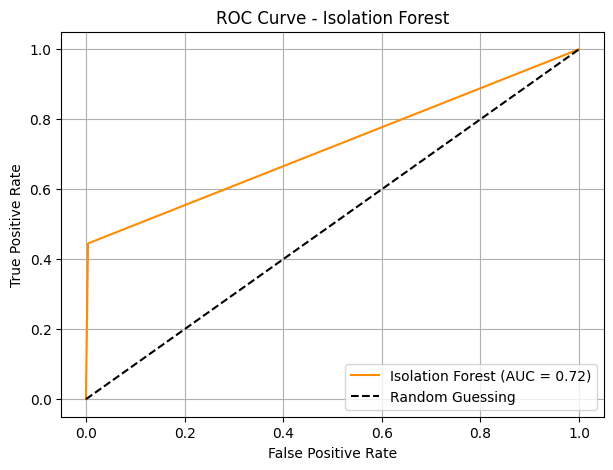

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_true = df['Class']
y_pred = df['anomaly']

# True labels and predictions
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Isolation Forest (AUC = %0.2f)' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()




---



# AutoEncoders
***(Bonus part for comparison)***

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [19]:
# Separate fraud and normal
fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

# Only use normal transactions to train
X_train = normal_df.drop(columns=['Class'])
X_test = pd.concat([fraud_df, normal_df.sample(n=50000, random_state=42)])  # 50k Sample to train, mix for testing

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test.drop(columns=['Class']))
y_test = X_test['Class'].values


In [20]:
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │           527 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319 (5.15 KB)

 Trainable params: 1,319 (5.15 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7900 - val_loss: 0.5911
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5520 - val_loss: 0.5398
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4933 - val_loss: 0.5186
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4736 - val_loss: 0.5170
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4702 - val_loss: 0.5142
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4648 - val_loss: 0.5110
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4634 - val_loss: 0.5068
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4622 - val_loss: 0.5039
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4608 - val_loss: 0.4986
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4553 - val_loss: 0.4981


In [22]:
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [25]:
threshold = np.percentile(mse, 95)  # adjust for sensitivity
print("Reconstruction error threshold:", threshold)

y_pred = (mse > threshold).astype(int)


Reconstruction error threshold: 1.1662679525715223


In [26]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))


[[47883  2117]
 [   84   408]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     50000
           1       0.16      0.83      0.27       492

    accuracy                           0.96     50492
   macro avg       0.58      0.89      0.62     50492
weighted avg       0.99      0.96      0.97     50492

ROC AUC Score: 0.8934641463414633


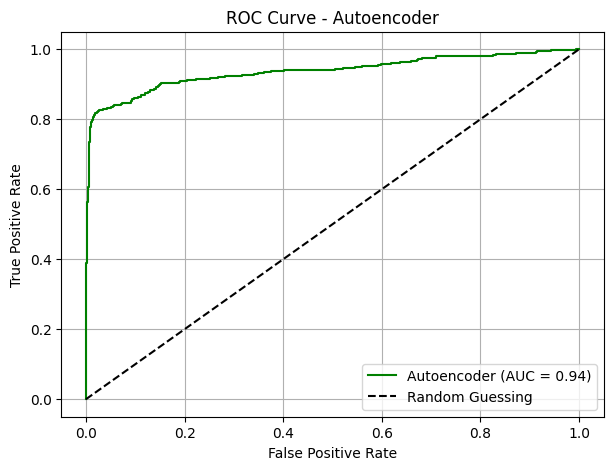

In [27]:
# Already defined earlier:
# mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
# y_test = true labels (0 or 1)

fpr_ae, tpr_ae, _ = roc_curve(y_test, mse)
roc_auc_ae = auc(fpr_ae, tpr_ae)

plt.figure(figsize=(7,5))
plt.plot(fpr_ae, tpr_ae, label='Autoencoder (AUC = %0.2f)' % roc_auc_ae, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Step 5: Model Comparison Summary

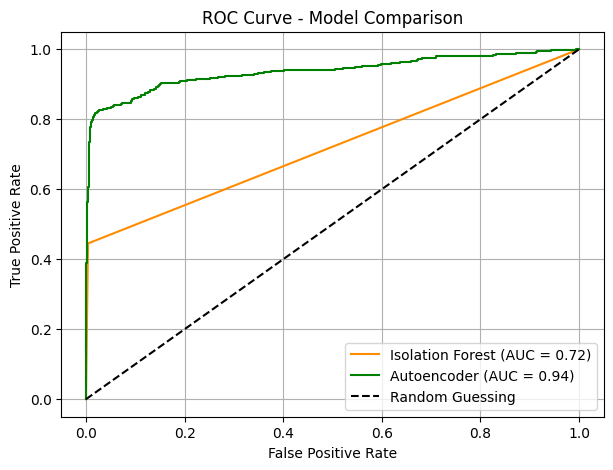

In [28]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Isolation Forest (AUC = %0.2f)' % roc_auc, color='darkorange')
plt.plot(fpr_ae, tpr_ae, label='Autoencoder (AUC = %0.2f)' % roc_auc_ae, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


**✅ Conclusion**

Autoencoder outperformed Isolation Forest in all key metrics, especially in recall and AUC.

Isolation Forest is lightweight and good for baseline, but Autoencoder is preferred when higher fraud detection rates are required.